# Covid-19 Time Series Modeling

- Flex
- Instructor: Morgan Jones
- Blog: 
- Date of Review:

# Abstract

# Introduction

## The Business Problem

- Covid-19 Epidemic

##  This Project | The Business + Business Problem

- company akin to WHO --> create time series model of the epidemic to forcast 

## The Data Source
 - git hub read me description --> https://github.com/owid/covid-19-data/blob/master/public/data/README.md
 
 - Our World in Data [Kaggle](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset)
 
 - Our World in Data, original site --> https://ourworldindata.org/explorers/coronavirus-data-explorer
 
 - WHO data

### Reproducing via Google CoLabs

- detailed instructions on how to download AND
- write script to download data from source(s)

In [ ]:
# Import Needed Libraries

import json
import shutil
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from pmdarima.arima import auto_arima

from prophet import Prophet

In [2]:
# Versions
import sys
import matplotlib
import sklearn
import statsmodels
import prophet
import pmdarima

print('Python | ', sys.version[:5])
print('Pandas | ', pd.__version__)
print('Numpy | ', np.__version__)
print('SciPy | ', scipy.__version__)
print('Matplotlib | ', matplotlib.__version__)
print('Seaborn | ', sns.__version__)
print('Geopandas | ', gpd.__version__)
print('SciKit Learn | ', sklearn.__version__)
print('Stats Models | ', statsmodels.__version__)
print('pmdarima | ', pmdarima.__version__)
print('Prophet | ', prophet.__version__)

Python |  3.8.5
Pandas |  1.1.3
Numpy |  1.24.4
SciPy |  1.10.1
Matplotlib |  3.3.1
Seaborn |  0.11.0
Geopandas |  0.13.2
SciKit Learn |  1.3.2
Stats Models |  0.14.1
pmdarima |  2.0.4
Prophet |  1.1.5


In [3]:
# Prep Google CoLab environment to download data from Kaggle
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

#username = ''  ## Your Kaggle username
#api_key = ''  ## Your Kaggle API key

#api_token = {"username": username,
#             "key": api_key}

#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset from Kaggle
#!kaggle datasets download -d caesarmario/our-world-in-data-covid19-dataset
#!kaggle datasets download -d paultimothymooney/latitude-and-longitude-for-every-country-and-state

In [5]:
# This cell unzips the downloaded data
#shutil.unpack_archive('our-world-in-data-covid19-dataset.zip', '/content')
#shutil.unpack_archive('latitude-and-longitude-for-every-country-and-state.zip', '/content')

# Data Exploration

- what data are we working with?
- columns? which ones keep/disregard + why?
- what is business prob? need to modify data in any way to address this?
- look for trends + seasonality
- look for key 'turning points' --> when vaccine was released 
    - provide supporting evidence here if needed
- other descriptive statistics for a feel of what data we are working with
    - graphs of data over time (deaths, confirmed cases, recovered, vaccinated)
    - histograms?
    - visual of data on country or region basis?

In [6]:
df = pd.read_csv('owid-covid-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350085 entries, 0 to 350084
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    350085 non-null  object 
 1   continent                                   333420 non-null  object 
 2   location                                    350085 non-null  object 
 3   date                                        350085 non-null  object 
 4   total_cases                                 312088 non-null  float64
 5   new_cases                                   340457 non-null  float64
 6   new_cases_smoothed                          339198 non-null  float64
 7   total_deaths                                290501 non-null  float64
 8   new_deaths                                  340511 non-null  float64
 9   new_deaths_smoothed                         339281 non-null  float64
 


| Columns | Description | 
|:--|:--| 
| `continent` | Continent of the geographical location | 
| `location` | Geographical location | 
| `date` | Date of observation | 
| `new_cases` | New confirmed cases of COVID-19. Counts can include probable cases, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA | 
| `new_cases_smoothed` | New confirmed cases of COVID-19 (7-day smoothed). Counts can include probable cases, where reported. | 
| `new_deaths` | New deaths attributed to COVID-19. Counts can include probable deaths, where reported. In rare cases where our source reports a negative daily change due to a data correction, we set this metric to NA. |
| `new_deaths_smoothed` | New deaths attributed to COVID-19 (7-day smoothed). Counts can include probable deaths, where reported. |
| `reproduction_rate` | Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database | 
| `icu_patients` | Number of COVID-19 patients in intensive care units (ICUs) on a given day. |
| `hosp_patients` | Number of COVID-19 patients in hospital on a given day. |
| `new_tests` | New tests for COVID-19 (only calculated for consecutive days). |
| `new_tests_smoothed` | New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `positive_rate` | The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case). |
| `test_units` | Units used by the location to report its testing data. A country file can't contain mixed units. All metrics concerning testing data use the specified test unit. Valid units are 'people tested' (number of people tested), 'tests performed' (number of tests performed. a single person can be tested more than once in a given day) and 'samples tested' (number of samples tested. In some cases, more than one sample may be required to perform a given test.) | 
| `people_vaccinated` | Total number of people who received at least one vaccine dose | 
| `new_people_vaccinated_smoothed` | Daily number of people receiving their first vaccine dose (7-day smoothed) | 
| `new_vaccinations` | New COVID-19 vaccination doses administered (only calculated for consecutive days) | 
| `new_vaccinations_smoothed` | New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window |
| `total_boosters` | Total number of COVID-19 vaccination booster doses administered (doses administered beyond the number prescribed by the vaccination protocol) |
| `stringency_index` | Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response). | 
| `population_density` | Number of people divided by land area, measured in square kilometers, most recent year available | 
| `median_age` | Median age of the population, UN projection for 2020 | 
| `aged_70_older` | Share of the population that is 70 years and older in 2015 |
| `gdp_per_capita` | Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available | 
| `extreme_poverty` | Share of the population living in extreme poverty, most recent year available since 2010 | 
| `cardiovasc_death_rate` | Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people) | 
| `diabetes_prevalence` | Dabetes prevalence (% of population aged 20 to 79) in 2017 |
| `female_smokers` | Share of women who smoke, most recent year available | 
| `male_smokers` | Share of men who smoke, most recent year available | 
| `handwashing_facilities` | Share of the population with basic handwashing facilities on premises, most recent year available |
| `hospital_beds_per_thousand` | Hospital beds per 1,000 people, most recent year available since 2010 |
| `life_expectancy` | Life expectancy at birth in 2019 | 
| `human_development_index` | A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506 | 
| `population` | Population (latest available values). See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_latest.csv for full list of sources | 



In [7]:
# Choose which columns to use/drop
cols_to_use = ['continent', 'location', 'date', 'new_cases_smoothed', 'new_deaths_smoothed',
               'reproduction_rate', 'icu_patients', 'hosp_patients', 'new_tests_smoothed', 
               'positive_rate', 'tests_units', 'people_vaccinated', 'new_people_vaccinated_smoothed',
               'total_boosters', 'new_vaccinations_smoothed', 'stringency_index', 'population_density', 
               'median_age', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate',
               'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 
               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'population']
df1 = df[cols_to_use]

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350085 entries, 0 to 350084
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   continent                       333420 non-null  object 
 1   location                        350085 non-null  object 
 2   date                            350085 non-null  object 
 3   new_cases_smoothed              339198 non-null  float64
 4   new_deaths_smoothed             339281 non-null  float64
 5   reproduction_rate               184817 non-null  float64
 6   icu_patients                    37615 non-null   float64
 7   hosp_patients                   38902 non-null   float64
 8   new_tests_smoothed              103965 non-null  float64
 9   positive_rate                   95927 non-null   float64
 10  tests_units                     106788 non-null  object 
 11  people_vaccinated               75911 non-null   float64
 12  new_people_vacci

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

<ipython-input-9-e448b256dc75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['date'])


In [10]:
lat_long = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
lat_long = lat_long[['latitude', 'longitude', 'country']]
lat_long.head()

,latitude,longitude,country
0,42.546245,1.601554,Andorra
1,23.424076,53.847818,United Arab Emirates
2,33.939110,67.709953,Afghanistan
3,17.060816,-61.796428,Antigua and Barbuda
4,18.220554,-63.068615,Anguilla


In [11]:
df2 = pd.merge(df1,
              lat_long,
              left_on='location',
              right_on='country',
              how='left')

In [12]:
# Drop not countries
loc_to_drop = ['Africa', 'Asia', 'Europe', 'European Union', 'High income', 
               'Low income', 'Lower middle income', 'North America', 'Oceania', 
               'South America', 'Upper middle income', 'World']

df2 = df2[~df2['location'].isin(loc_to_drop)]

<ipython-input-13-60455037b984>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


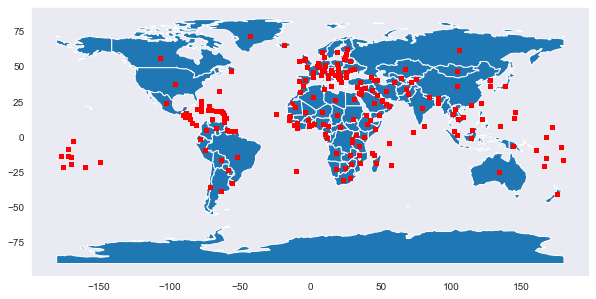

In [13]:
# https://stackoverflow.com/a/53233489

geometry = [Point(xy) for xy in zip(df2['longitude'], df2['latitude'])]
gdf = GeoDataFrame(df2[['longitude', 'latitude']], geometry=geometry)   

# this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Talk about choice here to use the different continents as the different zones based off map -- countries in which we have data points from.

In [14]:
# Drop non-countries from df1
df1 = df1[~df1['location'].isin(loc_to_drop)]

In [15]:
df1['continent'].isna().sum()

0

In [16]:
df1['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania', 'North America',
       'South America'], dtype=object)

In [17]:
# Create the different dataframes that we will use for modeling

df_asia = df1[df1['continent'] == 'Asia']
df_eu = df1[df1['continent'] == 'Europe']
df_af = df1[df1['continent'] == 'Africa']
df_oc = df1[df1['continent'] == 'Oceania']
df_na = df1[df1['continent'] == 'North America']

df_sa = df1[df1['continent'] == 'South America']

In [18]:
data = [('Asia', df_asia), ('Europe', df_eu), ('Africa', df_af), 
        ('Oceana', df_oc), ('North America', df_na), ('South America', df_sa)]

for (name, df) in data:
    nulls = df.isna().sum().sum()
    print(name, nulls)

Asia 610565
Europe 764416
Africa 759079
Oceana 515862
North America 792359
South America 185857


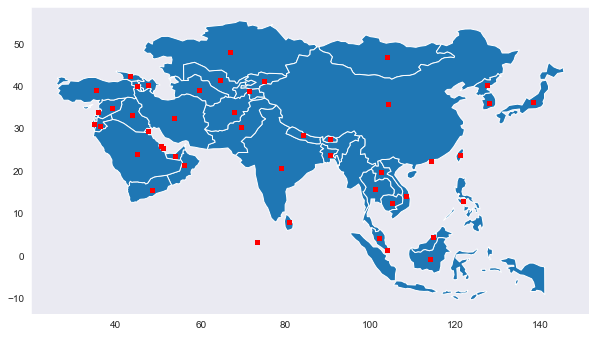

In [19]:
df2_asia = df2[df2['continent'] == 'Asia']

geometry = [Point(xy) for xy in zip(df2_asia['longitude'], df2_asia['latitude'])]
gdf = GeoDataFrame(df2_asia[['longitude', 'latitude']], geometry=geometry)

asia = world[world['continent'] == 'Asia']
gdf.plot(ax=asia.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

#### Train/Validate/Test Split?

- Train/val/test split AFTER aggregate -- so long as aggregation does not inlucde/span dates that will cross split!
- Example, all the averages by date are fine, because those are consolidated in their own group.  Yes still data leakage because making decisions on nulls in val + test groups but as long as long as numbers/averages don't take into account information crossing split date ranges -- good.

In [20]:
unique_dates_total = len(df_asia['date'].unique())
first_80_perc = unique_dates_total * .8
train_end = df_asia['date'].unique()[int(first_80_perc)]
print('Last train date:', train_end)

val_perc = first_80_perc + (unique_dates_total * .1)
val_end = df_asia['date'].unique()[int(val_perc)]
print('Last validation date:', val_end)

Last train date: 2023-01-19T00:00:00.000000000
Last validation date: 2023-06-07T00:00:00.000000000


In [21]:
# Check percent missing by variable
num_rows = len(df_asia['date'])
for var in df_asia.columns:
    missing = df_asia[var].isna().sum()
    if missing > 0:
        print(var, '{}%'.format(round(missing/num_rows*100, 1)))

new_cases_smoothed 6.4%
new_deaths_smoothed 6.4%
reproduction_rate 33.9%
icu_patients 94.9%
hosp_patients 96.0%
new_tests_smoothed 61.2%
positive_rate 64.5%
tests_units 60.5%
people_vaccinated 75.0%
new_people_vaccinated_smoothed 44.4%
total_boosters 86.9%
new_vaccinations_smoothed 44.3%
stringency_index 26.4%
population_density 4.9%
median_age 1.0%
aged_70_older 1.0%
gdp_per_capita 6.9%
extreme_poverty 44.0%
cardiovasc_death_rate 4.0%
diabetes_prevalence 6.1%
female_smokers 24.0%
male_smokers 24.0%
handwashing_facilities 48.0%
hospital_beds_per_thousand 10.0%
life_expectancy 1.0%
human_development_index 6.1%


In [22]:
# Check percent missing by country
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    num_cells = len(df_asia[mask]) * 30
    missing = df_asia[mask].isna().sum().sum()
    percent = round(missing/num_cells*100, 1)
    if percent > 40:
        print(country, '{}%'.format(percent))

Hong Kong 47.2%
Macao 58.1%
North Korea 53.2%
Northern Cyprus 80.2%
Syria 47.3%
Taiwan 54.7%


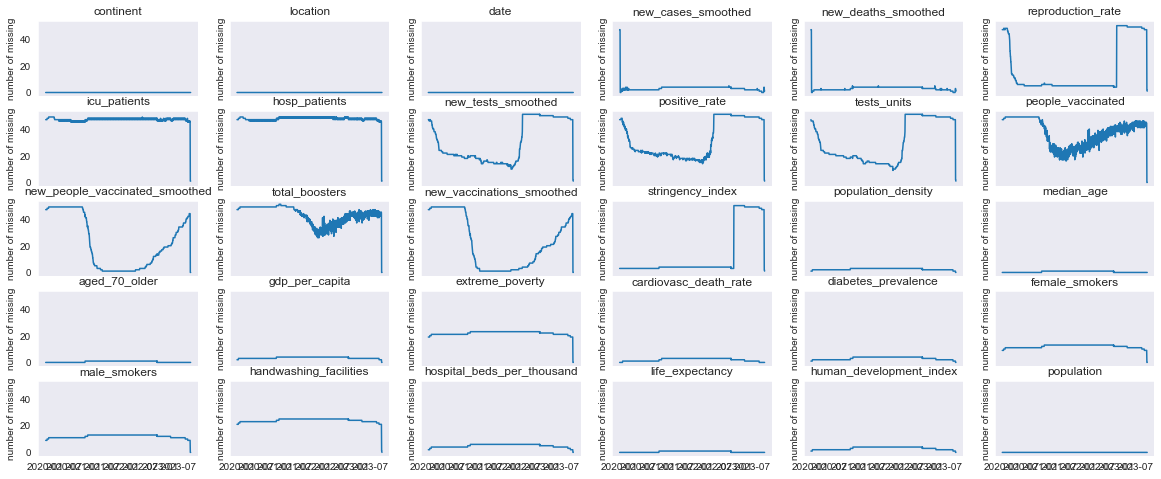

In [23]:
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(20,8), sharey=True, sharex=True)

for i,var in enumerate(df_asia.columns):
    y = []
    for date in df_asia['date'].unique():
        y.append(df_asia[df_asia['date'] == date][var].isna().sum())
    
    row = i // 6
    col = i % 6
    ax = axes[row, col]   
    
    ax.plot(df_asia['date'].unique(), y)
    ax.set_title(var)
    ax.set_ylabel('number of missing');

In [24]:
# Based on above, drop
    # Country: Northern Cyprus, Hong Kong, and Macao
    # Variable: reproduction_rate, icu_patients, hosp_patients, 
        # and total_boosters (maybe positive_rate, new_tests_smoothed, and test_units too)

# Drop countries
mask = (df_asia['location'] == 'Northern Cyprus') | (df_asia['location'] == 'Hong Kong') | (df_asia['location'] == 'Macao')
df_asia = df_asia[~mask]
    
# Drop variables
col_to_drop = ['icu_patients', 'hosp_patients', 'new_tests_smoothed', 'positive_rate', 'tests_units', 'reproduction_rate',
              'new_people_vaccinated_smoothed', 'total_boosters', 'extreme_poverty', 'handwashing_facilities']
df_asia = df_asia.drop(col_to_drop, axis=1)

In [25]:
# Recheck missing values be variable
num_rows = len(df_asia['date'])
for var in df_asia.columns:
    missing = df_asia[var].isna().sum()
    if missing > 0:
        print(var, '{}%'.format(round(missing/num_rows*100, 1)))

new_cases_smoothed 2.5%
new_deaths_smoothed 2.4%
people_vaccinated 76.0%
new_vaccinations_smoothed 45.6%
stringency_index 25.9%
population_density 4.1%
gdp_per_capita 6.2%
diabetes_prevalence 4.1%
female_smokers 20.8%
male_smokers 20.8%
hospital_beds_per_thousand 6.2%
human_development_index 4.1%


In [26]:
# Recheck missing values by country
for country in df_asia['location'].unique():
    mask = df_asia['location'] == country
    num_cells = len(df_asia[mask]) * 30
    missing = df_asia[mask].isna().sum().sum()
    percent = round(missing/num_cells*100, 1)
    if percent > 20:
        print(country, '{}%'.format(percent))

North Korea 23.4%
Syria 22.1%
Taiwan 33.6%


| Variable | How to Handel missing values | 
|:---|:--|
| `new_cases_smoothed` | Input 0.  NaN only entered when negative values present due to corrective reporting. | 
| `new_deaths_smoothed` | Input 0. NaN only entered when negative values present due to corrective reporting. | 
| `people_vaccinated` | Forward fill for missing values after vaccine released by country. | 
| `new_vaccinations_smoothed` | Input 0. Missing values prior to vaccine release date are 0. Assume no new vaccinations or reporting error for NaN values after vaccine date. | 
| `stringency_index` | By country, forward fill. Assuming a missing value means it was not reported and no change between previous assigned value. For validation & test sets with no information to forward, assume 0 value (many Covid-19 policies ended in 2023).| 
| `population_density` | By country, fill with average value.  If country missing all values, see if can research and input. |
| `gdp_per_capita` | Fill with average. | 
| `diabetes_prevalence` | Fill with average. |
| `female_smokers` | Fill with average. |
| `male_smokers` | Fill with average. | 
| `hospital_beds_per_thousand` | Fill with average. | 
| `human_development_index` | Fill with average. | 

In [27]:
# Input 0 for assigned columns
    # True for train, validate, and test groups -- no need to split
fill_values = {'new_cases_smoothed' : 0, 'new_deaths_smoothed':0, 'new_vaccinations_smoothed':0}
df_asia.fillna(fill_values, inplace=True)

In [28]:
# People Vaccinated -- Forward fill by country (start with 0)

# Start with 0
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country)
    mask2 = (df_asia['date'] == (df_asia.loc[mask, 'date'].unique().min()))
    mask_all = mask & mask2
    df_asia.loc[mask_all, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].fillna(0)

# Train Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] < train_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('train', country)
        
# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('test', country)
        

val Afghanistan
val Armenia
val Azerbaijan
val Bahrain
val Bangladesh
val Bhutan
val Brunei
val Cambodia
val Georgia
val Indonesia
val Iran
val Iraq
val Jordan
val Kazakhstan
val Kuwait
val Laos
val Lebanon
val Maldives
val Mongolia
val Myanmar
val Nepal
val North Korea
val Oman
val Pakistan
val Palestine
val Qatar
val Saudi Arabia
val Sri Lanka
val Syria
val Taiwan
val Tajikistan
val Thailand
val Timor
val Turkey
val Turkmenistan
val United Arab Emirates
val Uzbekistan
val Vietnam
val Yemen
test Afghanistan
test Armenia
test Azerbaijan
test Bahrain
test Bhutan
test Brunei
test China
test Georgia
test India
test Indonesia
test Iran
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Kuwait
test Laos
test Lebanon
test Maldives
test Mongolia
test Myanmar
test Nepal
test North Korea
test Oman
test Pakistan
test Palestine
test Philippines
test Qatar
test Saudi Arabia
test Singapore
test South Korea
test Sri Lanka
test Syria
test Taiwan
test Tajikistan
test Thailand
test Timor

Two options here:
1. Back fill from known values in Validation + Test Sets
   - this would avoid any data leakage from the training set into the validation + test sets but not be quite as accurate
2. Forward fill information from train set into validation + test sets
    - this would be much more accurate (this is a culmuative value per country and thus be the more accurate approach, but would mean data leakage is occuring.
3. Drop the variable

In [29]:
# Try back filling

# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].bfill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].bfill()  
    if df_asia.loc[mask, 'people_vaccinated'].isna().sum() > 0:
        print('test', country)

val Azerbaijan
val Bahrain
val Bhutan
val Georgia
val Iraq
val Jordan
val Kazakhstan
val Laos
val Lebanon
val Mongolia
val North Korea
val Oman
val Palestine
val Sri Lanka
val Thailand
val Turkey
val United Arab Emirates
test Azerbaijan
test Bahrain
test Bhutan
test China
test Georgia
test Indonesia
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Laos
test Lebanon
test Maldives
test Mongolia
test Myanmar
test North Korea
test Oman
test Palestine
test Philippines
test Qatar
test Saudi Arabia
test Singapore
test South Korea
test Sri Lanka
test Syria
test Tajikistan
test Thailand
test Turkey
test United Arab Emirates


In [30]:
# That did not work -- rather than dropping the variable we will forward fill completely. 
    # Yes this will mean a bit of data leakage, but it is reasonable to assume that if we knew the previous number of total
        # people vaccinated that this number will be the same moving forward if no new reports/updates made (no new vaccinations)
        
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) 
    df_asia.loc[mask, 'people_vaccinated'] = df_asia.loc[mask, 'people_vaccinated'].ffill()
    
df_asia['people_vaccinated'].isna().sum()

0

In [31]:
# stringency_index
df_asia['stringency_index'].isna().sum()

17235

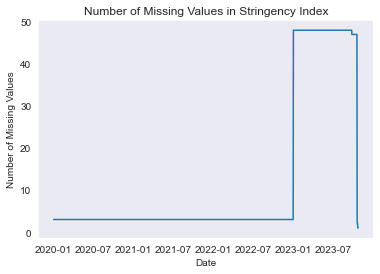

In [32]:
y = []
for date in df_asia['date'].unique():
    y.append(df_asia[df_asia['date'] == date]['stringency_index'].isna().sum())
    
fig, ax = plt.subplots()
ax.plot(df_asia['date'].unique(), y)
ax.set_title('Number of Missing Values in Stringency Index')
ax.set_ylabel('Number of Missing Values')
ax.set_xlabel('Date');

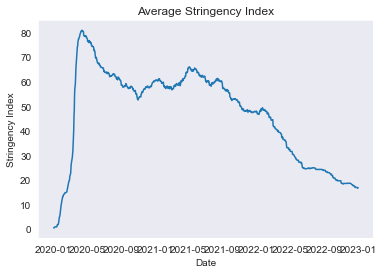

In [33]:
y = []
for date in df_asia['date'].unique():
    avg = np.mean(df_asia[df_asia['date'] == date]['stringency_index'])
    y.append(avg)

fig, ax = plt.subplots()
ax.plot(df_asia['date'].unique(), y)
ax.set_title('Average Stringency Index')
ax.set_ylabel('Stringency Index')
ax.set_xlabel('Date');

In [34]:
# Train Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] < train_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('train', country)
        
# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].ffill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('test', country)

train Armenia
train Maldives
train North Korea
val Afghanistan
val Armenia
val Azerbaijan
val Bahrain
val Bangladesh
val Bhutan
val Brunei
val Cambodia
val China
val Georgia
val India
val Indonesia
val Iran
val Iraq
val Israel
val Japan
val Jordan
val Kazakhstan
val Kuwait
val Kyrgyzstan
val Laos
val Lebanon
val Malaysia
val Maldives
val Mongolia
val Myanmar
val Nepal
val North Korea
val Oman
val Pakistan
val Palestine
val Philippines
val Qatar
val Saudi Arabia
val Singapore
val South Korea
val Sri Lanka
val Syria
val Taiwan
val Tajikistan
val Thailand
val Timor
val Turkey
val Turkmenistan
val United Arab Emirates
val Uzbekistan
val Vietnam
val Yemen
test Afghanistan
test Armenia
test Azerbaijan
test Bahrain
test Bangladesh
test Bhutan
test Brunei
test Cambodia
test China
test Georgia
test India
test Indonesia
test Iran
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Kuwait
test Kyrgyzstan
test Laos
test Lebanon
test Malaysia
test Maldives
test Mongolia
test Myanmar
t

In [35]:
# So we have three countries where the stringency index was never reported, and, as seen with `people_vaccinated`, 
    # most countries stopped reporting on this value starting in 2023.

# For the countries that never reported we will put the average for the day in -- this value will be averaged in aggregate

for date in df_asia.loc[df_asia['date']<train_end,'date'].unique():
    avg = np.mean(df_asia[df_asia['date'] == date]['stringency_index'])
    for country in df_asia[df_asia['stringency_index'].isna()]['location'].unique():
        mask = (df_asia['location'] == country) & (df_asia['date'] == date)
        df_asia.loc[mask, 'stringency_index'] = avg

For the Validation + test sets again, some options:

1. Back fill from known values in Validation + Test Sets (although as we saw above this might not work if ALL values are missing for each country.
2. Forward fill information from train set into validation + test sets
    - this would be much more accurate (this is a culmuative value per country and thus be the more accurate approach, but would mean data leakage is occuring.
3. Input 0 for this variable in Validation + Test Sets
    - This is reasonable only because we know that most contries dropped most if not all of their Covid-19 protections by 2023.
4. Drop the variable

In [36]:
# We will try option 1 and if that fails move to option 3

# Try backfilling:
# Validation Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= train_end) & (df_asia['date'] < val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].bfill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('val', country)
        
# Test Set
for country in df_asia['location'].unique():
    mask = (df_asia['location'] == country) & (df_asia['date'] >= val_end)
    df_asia.loc[mask, 'stringency_index'] = df_asia.loc[mask, 'stringency_index'].bfill()  
    if df_asia.loc[mask, 'stringency_index'].isna().sum() > 0:
        print('test', country)

val Afghanistan
val Armenia
val Azerbaijan
val Bahrain
val Bangladesh
val Bhutan
val Brunei
val Cambodia
val China
val Georgia
val India
val Indonesia
val Iran
val Iraq
val Israel
val Japan
val Jordan
val Kazakhstan
val Kuwait
val Kyrgyzstan
val Laos
val Lebanon
val Malaysia
val Maldives
val Mongolia
val Myanmar
val Nepal
val North Korea
val Oman
val Pakistan
val Palestine
val Philippines
val Qatar
val Saudi Arabia
val Singapore
val South Korea
val Sri Lanka
val Syria
val Taiwan
val Tajikistan
val Thailand
val Timor
val Turkey
val Turkmenistan
val United Arab Emirates
val Uzbekistan
val Vietnam
val Yemen
test Afghanistan
test Armenia
test Azerbaijan
test Bahrain
test Bangladesh
test Bhutan
test Brunei
test Cambodia
test China
test Georgia
test India
test Indonesia
test Iran
test Iraq
test Israel
test Japan
test Jordan
test Kazakhstan
test Kuwait
test Kyrgyzstan
test Laos
test Lebanon
test Malaysia
test Maldives
test Mongolia
test Myanmar
test Nepal
test North Korea
test Oman
test Pakis

In [37]:
df_asia['stringency_index'].isna().sum()

13089

In [38]:
# That clearly did not work -- move forward with filling nulls with 0 for 2023 onwards (validation + test sets)
df_asia['stringency_index'] = df_asia['stringency_index'].fillna(0)

In [39]:
df_asia['stringency_index'].isna().sum()

0

In [40]:
# Population Density
df_asia[df_asia['population_density'].isna()]['location'].unique()

array(['Syria', 'Taiwan'], dtype=object)

In [41]:
# Syria - 113 in 2020 -- use for all
    # https://worldpopulationreview.com/countries/syria-population
mask = df_asia['location'] == 'Syria'    
df_asia.loc[mask, 'population_density'] = df_asia.loc[mask, 'population_density'].fillna(113)

# Taiwan - 673
    # https://worldpopulationreview.com/countries/taiwan-population
mask = df_asia['location'] == 'Taiwan'    
df_asia.loc[mask, 'population_density'] = df_asia.loc[mask, 'population_density'].fillna(673)

In [42]:
df_asia['population_density'].isna().sum()

0

In [43]:
# For static numbers for country, fill missing countries with continent average
fill_avg = ['gdp_per_capita', 'diabetes_prevalence', 'female_smokers', 
            'male_smokers', 'hospital_beds_per_thousand', 'human_development_index']

for var in fill_avg:
    df_asia.loc[:, var] = df_asia.loc[:, var].fillna(np.mean(df_asia[var]))

In [44]:
# Check Total Missing Values
df_asia.isna().sum().sum()

0

In [45]:
# Consolidate Data -- one row per day
df_asia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66452 entries, 0 to 347314
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   continent                   66452 non-null  object        
 1   location                    66452 non-null  object        
 2   date                        66452 non-null  datetime64[ns]
 3   new_cases_smoothed          66452 non-null  float64       
 4   new_deaths_smoothed         66452 non-null  float64       
 5   people_vaccinated           66452 non-null  float64       
 6   new_vaccinations_smoothed   66452 non-null  float64       
 7   stringency_index            66452 non-null  float64       
 8   population_density          66452 non-null  float64       
 9   median_age                  66452 non-null  float64       
 10  aged_70_older               66452 non-null  float64       
 11  gdp_per_capita              66452 non-null  float64  

| Variable | How to aggregate |
|:--|:--|
|`continent` | drop |
| `location` | drop |
| `date` | unique value per day | 
| `new_cases_smoothed` | sum per day |
| `new_deaths_smoothed` | sum per day |
| `people_vaccinated` | sum per day (culmative value) |
| `new_vaccinations_smoothed` | sum per day |
| `stringency_index` | average per day |
| `population_density` | average (constant value) |
| `median_age` | average (constant value) |
| `aged_70_older` | average (constant value) |
| `gdp_per_capita` | average (constant value) |
| `cardiovasc_death_rate` | average (constant value) |
| `diabetes_prevalence` | average (constant value) |
| `female_smokers` | average (constant value)|
| `male_smokers` | average (constant value) |
| `hospital_beds_per_thousand` | average (constant value) |
| `life_expectancy` | average (constant value) |
| `human_developemnt_index` | average (constant value) |
| `population` | average (constant value) |

In [46]:
# Dictionary to create new data frame for time series
asia_ts_data = {}
asia_ts_data['date'] = df_asia['date'].unique()

# Average (constant value) variables
avg_cnst = ['population_density', 'median_age', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
            'diabetes_prevalence', 'female_smokers', 'male_smokers', 'hospital_beds_per_thousand', 
            'life_expectancy', 'human_development_index', 'population']

for var in avg_cnst:
    values_to_add = []
    asia_ts_data[var] = values_to_add.append(np.mean(df_asia[var])) 
    values_to_add = values_to_add * (len(df_asia['date'].unique()))
    asia_ts_data[var] = values_to_add

# Average per day
avg_daily = ['stringency_index']

for var in avg_daily:
    values_to_add = []
    
    for date in df_asia['date'].unique():
        mask = df_asia['date'] == date
        avg = np.mean(df_asia.loc[mask, var])
        values_to_add.append(avg)
        
    asia_ts_data[var] = values_to_add
    
# Sum per day
sum_daily = ['new_cases_smoothed', 'new_deaths_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed']

for var in sum_daily:
    values_to_add = []
    
    for date in df_asia['date'].unique():
        mask = df_asia['date'] == date
        sum_ = np.sum(df_asia.loc[mask, var])
        values_to_add.append(sum_)
        
    asia_ts_data[var] = values_to_add        

In [47]:
df_asia_ts = pd.DataFrame(asia_ts_data)
df_asia_ts.set_index('date', inplace=True)

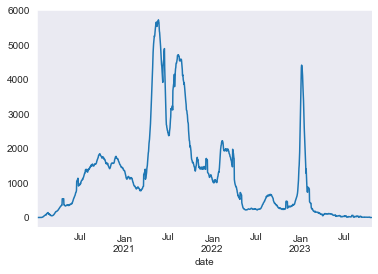

In [48]:
df_asia_ts['new_deaths_smoothed'].plot();

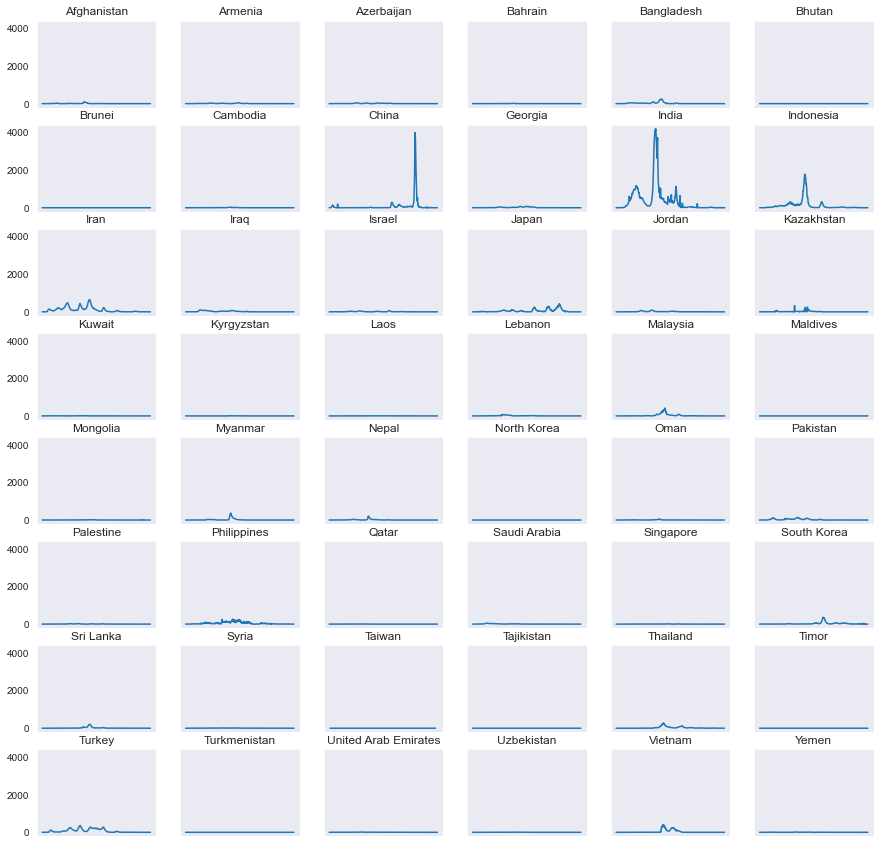

In [49]:
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'new_deaths_smoothed']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

- The spike in China in January 2023 is due to the end of 'zero COVID' standard -- however it is unreasonable to asusme that these numbers reported are accurate for deaths on a single day.
- The spike in India in June of 2021 is due in part to the Delta Variant that was rampent at the time in conjunction to India starting to more accuratly report number of deaths due to the disease.  However, again, it is unreasonable to assume that 4000 people died on a single day.


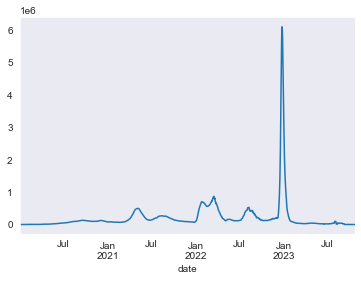

In [50]:
df_asia_ts['new_cases_smoothed'].plot();

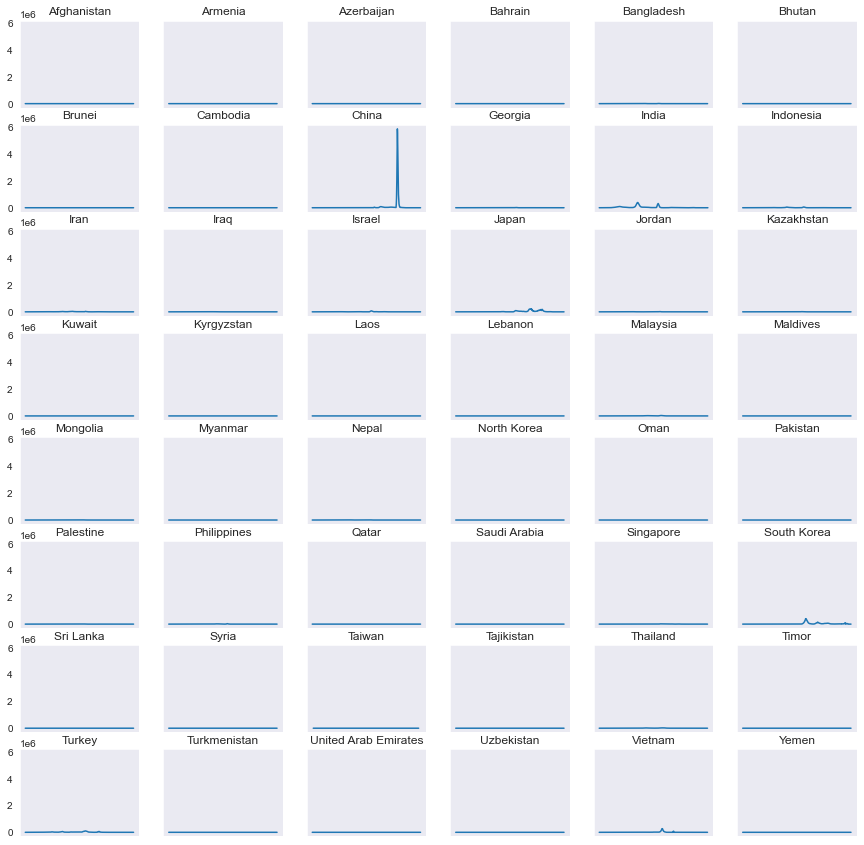

In [51]:
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'new_cases_smoothed']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

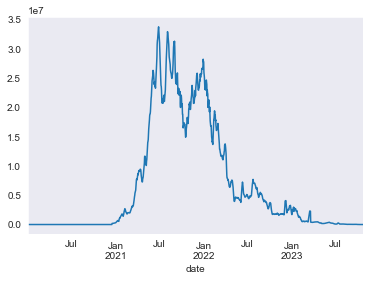

In [52]:
df_asia_ts['new_vaccinations_smoothed'].plot();

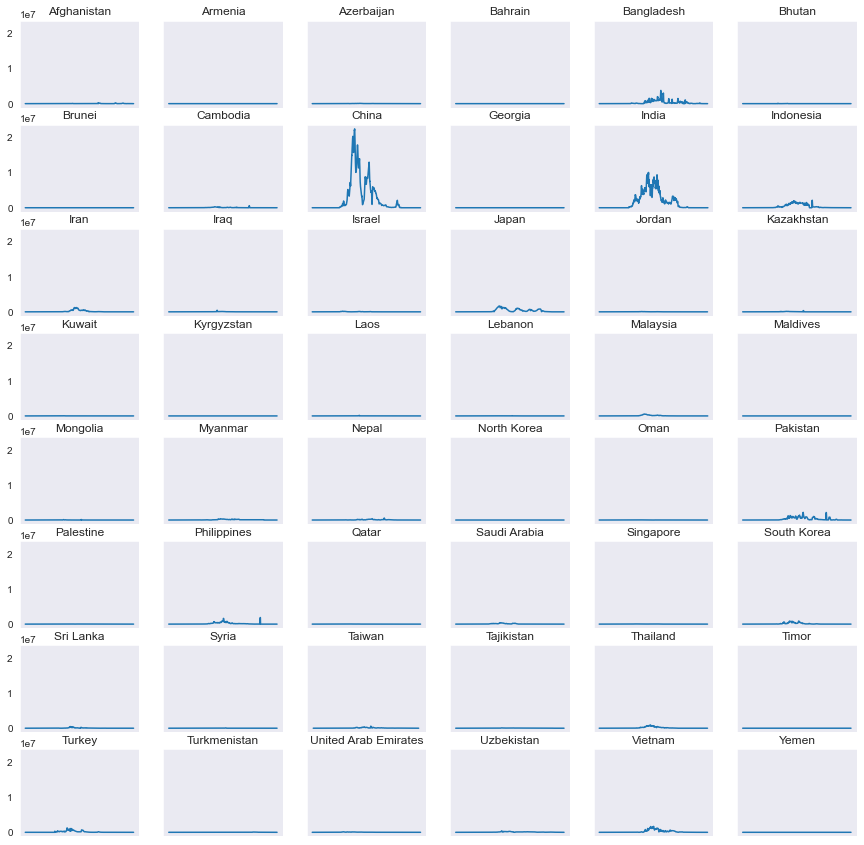

In [53]:
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'new_vaccinations_smoothed']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

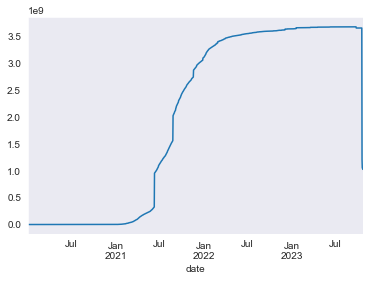

In [54]:
df_asia_ts['people_vaccinated'].plot();

In [55]:
df_asia_ts['people_vaccinated'][-8:]

date
2023-10-16    3.656579e+09
2023-10-17    3.656579e+09
2023-10-18    3.656579e+09
2023-10-19    1.207039e+09
2023-10-20    1.055535e+09
2023-10-21    1.055535e+09
2023-10-22    1.027419e+09
2023-10-23    1.027419e+09
Name: people_vaccinated, dtype: float64

In [56]:
# Last 5 days -- some countries must not have data included which is causing the averages to produce unexpected patterns in
    # this cumulative value of `people_vaccinated`.  Will move forward with using the value found on the 18th as the last 
    # value for these 5 days.

list_ = []
list_.append(df_asia_ts['people_vaccinated'][-8])
list_ = list_ * 5
df_asia_ts['people_vaccinated'][-5:] = list_

df_asia_ts['people_vaccinated'][-8:]

date
2023-10-16    3.656579e+09
2023-10-17    3.656579e+09
2023-10-18    3.656579e+09
2023-10-19    3.656579e+09
2023-10-20    3.656579e+09
2023-10-21    3.656579e+09
2023-10-22    3.656579e+09
2023-10-23    3.656579e+09
Name: people_vaccinated, dtype: float64

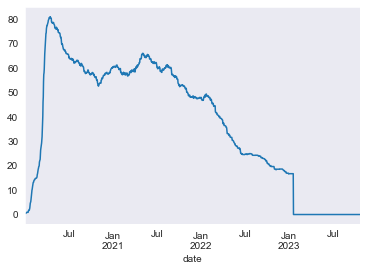

In [57]:
df_asia_ts['stringency_index'].plot();

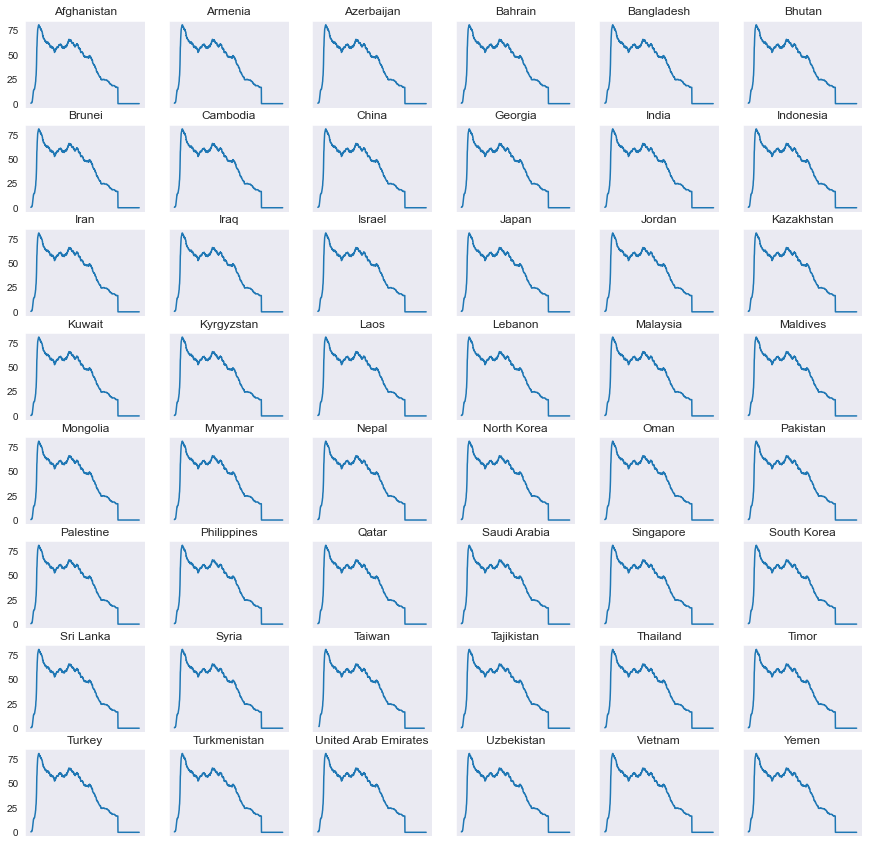

In [58]:
fig, axes = plt.subplots(ncols=6, nrows=8, figsize=(15,15), sharey=True, sharex=True)

for i,country in enumerate(df_asia['location'].unique()):
    row = i // 6 
    col = i % 6
    ax = axes[row, col]
    
    mask = df_asia['location'] == country
    x = df_asia.loc[mask, 'date'].unique()
    y = df_asia.loc[mask, 'stringency_index']
    
    ax.plot(x, y)
    ax.set_title(country)
    ax.set_xticks([]);

# Modeling

- Baseline --> naive forecasting (data shifted by one time-step)
- ARIMA and/or SARIMA
- grid search/pmdarima.auto_arima (?) 

In [59]:
# Train/val/test split AFTER aggregate -- so long as aggregation does not inlucde/span dates that will cross split!
    # Example, all the averages by date are fine, because those are consolidated in their own group.  Yes still data
        # leakage because making decisions on nulls in val + test groups but as long as long as numbers/averages don't
        # take into account information crossing split date ranges -- good.

# Train/Validate/Test Split
#df_asia_ts.set_index('date', inplace=True)

print('Train set will consist of approximately the first {} dates'.format(len(df_asia_ts.index) * .8))
print('Validate set will consist of approximately the next {} dates'.format(len(df_asia_ts.index) * .1))
print('Test set will consist of approximately the last {} dates'.format(len(df_asia_ts.index) * .1))

Train set will consist of approximately the first 1112.0 dates
Validate set will consist of approximately the next 139.0 dates
Test set will consist of approximately the last 139.0 dates


In [60]:
first_80_perc = len(df_asia_ts.index) * .8
mask = df_asia_ts.index[:int(first_80_perc)]
train = df_asia_ts.loc[mask]
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1112 entries, 2020-01-03 to 2023-01-18
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   population_density          1112 non-null   float64
 1   median_age                  1112 non-null   float64
 2   aged_70_older               1112 non-null   float64
 3   gdp_per_capita              1112 non-null   float64
 4   cardiovasc_death_rate       1112 non-null   float64
 5   diabetes_prevalence         1112 non-null   float64
 6   female_smokers              1112 non-null   float64
 7   male_smokers                1112 non-null   float64
 8   hospital_beds_per_thousand  1112 non-null   float64
 9   life_expectancy             1112 non-null   float64
 10  human_development_index     1112 non-null   float64
 11  population                  1112 non-null   float64
 12  stringency_index            1112 non-null   float64
 13  new_cases_smoot

In [61]:
val_perc = 139 + int(first_80_perc)
mask = df_asia_ts.index[int(first_80_perc):val_perc]
validate = df_asia_ts.loc[mask]
validate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2023-01-19 to 2023-06-06
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   population_density          139 non-null    float64
 1   median_age                  139 non-null    float64
 2   aged_70_older               139 non-null    float64
 3   gdp_per_capita              139 non-null    float64
 4   cardiovasc_death_rate       139 non-null    float64
 5   diabetes_prevalence         139 non-null    float64
 6   female_smokers              139 non-null    float64
 7   male_smokers                139 non-null    float64
 8   hospital_beds_per_thousand  139 non-null    float64
 9   life_expectancy             139 non-null    float64
 10  human_development_index     139 non-null    float64
 11  population                  139 non-null    float64
 12  stringency_index            139 non-null    float64
 13  new_cases_smooth

In [62]:
mask = df_asia_ts.index[val_perc:]
test = df_asia_ts.loc[mask]
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2023-06-07 to 2023-10-23
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   population_density          139 non-null    float64
 1   median_age                  139 non-null    float64
 2   aged_70_older               139 non-null    float64
 3   gdp_per_capita              139 non-null    float64
 4   cardiovasc_death_rate       139 non-null    float64
 5   diabetes_prevalence         139 non-null    float64
 6   female_smokers              139 non-null    float64
 7   male_smokers                139 non-null    float64
 8   hospital_beds_per_thousand  139 non-null    float64
 9   life_expectancy             139 non-null    float64
 10  human_development_index     139 non-null    float64
 11  population                  139 non-null    float64
 12  stringency_index            139 non-null    float64
 13  new_cases_smooth

## Basline  

- Naive Method -- next day will be the same value as the previous day.

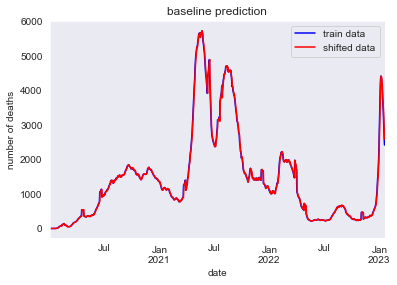

In [63]:
baseline = train['new_deaths_smoothed'].shift(1)

fig, ax = plt.subplots()
train['new_deaths_smoothed'].plot(ax=ax, c='b', label='train data')
baseline.plot(ax=ax, c='r', label='shifted data')
ax.set_title('baseline prediction')
ax.set_ylabel('number of deaths')
ax.legend();

In [64]:
# RMSE
baseline_error = np.sqrt(mean_squared_error(train['new_deaths_smoothed'][1:], 
                        baseline.dropna()))
baseline_error

74.98148522286566

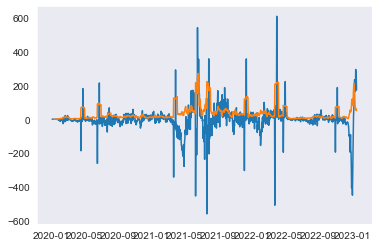

In [65]:
# look for trends -- want residuals to look like white noise
fig, ax = plt.subplots()

residuals = baseline[1:] - train['new_deaths_smoothed'][1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(7).std());

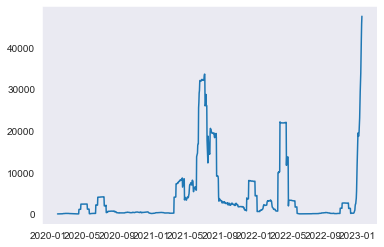

In [66]:
# check variance
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals.rolling(30).var());

In [ ]:
# use naive model to predict future values -- namely number of periods in validation set
# Then calculate AIC and RMSE
basline

## Model 2
- ARIMA or SARIMA
- Look at ACF and PACF
- AIC and RMSE for evaluation
- SARIMA grid search (if can)

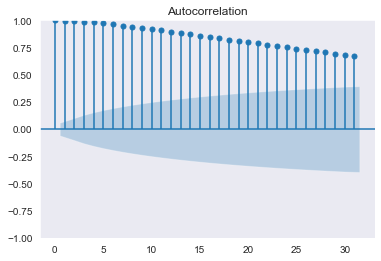

In [67]:
# ACF
fig, ax = plt.subplots()
plot_acf(train['new_deaths_smoothed'], ax=ax);

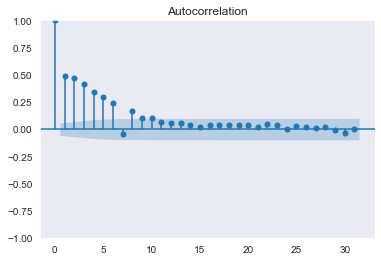

In [68]:
# Take the first difference -- now plot correlation
fig, ax =  plt.subplots()
data = train['new_deaths_smoothed'].diff().dropna()
plot_acf(data, ax=ax);

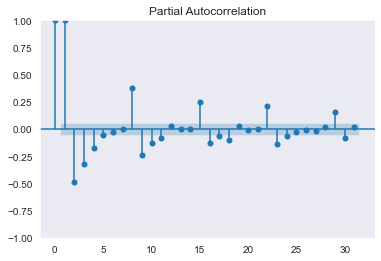

In [69]:
# PACF (correlation between current time periord + lags 
    # accounting for the correlation between the intermediate time periods)
fig, ax = plt.subplots()
plot_pacf(train['new_deaths_smoothed'], ax=ax, method='ols-adjusted');

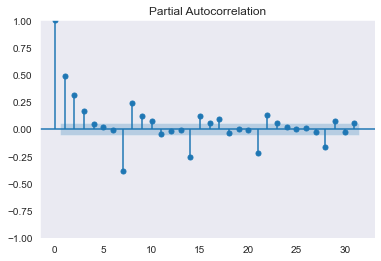

In [70]:
# PACF of differenced data
fig, ax =  plt.subplots()
data = train['new_deaths_smoothed'].diff().dropna()
plot_pacf(data, ax=ax, method='ols-adjusted');

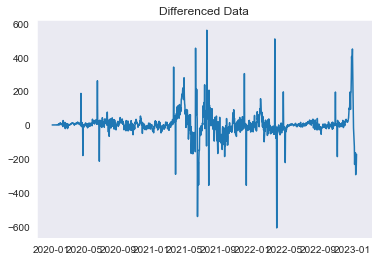

In [71]:
# Visualize Differenced Data
fig, ax = plt.subplots()
ax.plot(train['new_deaths_smoothed'].diff().dropna())
ax.set_title('Differenced Data');

In [72]:
# Check if the once differenced data is stationary

p_val = adfuller(train['new_deaths_smoothed'].diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print("Thus we can safely assume that the differenced data is stationary.")
else:
    print("Thus we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.8312712742959405e-06,
Thus we can safely assume that the differenced data is stationary.


- Evaluation Here prior to actually creating model
    - Once differenced data is stationary however, based on the ACF and PACF charts we believe that further differencing and/or adding some AR, MA, SAR or SMA terms might be necesary to account for the trends and/or seasonality.

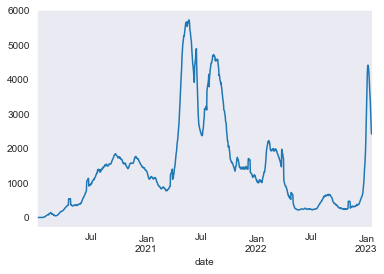

In [76]:
train['new_deaths_smoothed'].plot();

In [103]:
# Notes on auto_arima function parameters

# time series to train on + predict
y_train = train['new_deaths_smoothed']
# no constants
X_train = train[['new_cases_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed', 'stringency_index']]

# AR term
start_p = 1
max_p = 5 # default

# Order of non-seasonal first-differencing
d=None # default -- calculated
max_d = 2 # default -- from above we know 1 difference is stationary 

# MA term
start_q = 1
max_q = 5 #default

# Seasonality 
seasonal = False 

# Evaluaton to select best ARIMA model
information_criterion = 'aic' #default

# Level of significance
alpha = 0.05 # default

# Actually -- try default first
# Type of unit root test to use in order to detect stationarity 
#test = pmdarima.arima.ADFTest() # Augmented Dickey-Fuller

# Scoring is MSE

In [104]:
arima = auto_arima(y, X, start_p=start_p, start_q=start_q, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12292.082, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12725.721, Time=1.85 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12419.089, Time=0.82 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12555.246, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19405.347, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12274.985, Time=1.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12300.733, Time=1.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12273.326, Time=1.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12270.068, Time=1.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12269.356, Time=1.64 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=12270.779, Time=1.78 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12271.600, Time=1.81 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=12273.016, Time=1.88 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=12267.357, Time=1.52 sec
 ARIMA(3,1,0)(0,0,0

In [106]:
n_periods_pred = validate['new_deaths_smoothed'].shape[0]
X_val = validate[['new_cases_smoothed', 'people_vaccinated', 'new_vaccinations_smoothed', 'stringency_index']]

y_preds_arima = arima.predict(n_periods=n_periods_pred, X=val_X)

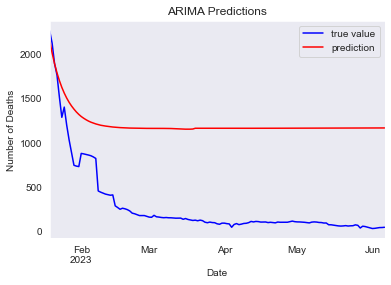

In [107]:
fig, ax = plt.subplots()

validate['new_deaths_smoothed'].plot(ax=ax, color='b', label='true value')
y_preds_arima.plot(ax=ax, color='r', label='prediction')
ax.set_title('ARIMA Predictions')
ax.set_ylabel('Number of Deaths')
ax.set_xlabel('Date')
ax.legend();

In [ ]:
# AIC on validation data


In [ ]:
# RMSE on validation data

## Model 3
- Multivariate timeseries

- Do I need to make the other variables stationary as well??
- 

## Linear Regresion
- Any way to combine this with time series?

### Facebook's Prophet

- The prophet library also imposes the strict condition that the input columns be named ds (the time column) and y (the metric column), so let's rename the columns in our ts DataFrame.

1. Create new prophet object
    - Model = Prophet(interval_width=0.95) # default uncertainty interval is 80%
2. Fit model to training data
    - Model.fit(data)
3. Forcast. provide new dataframe containing a `ds` column that holds the dates for which we want predictions --> `.make_future_dataframe()` helper method provided by prophet (OR for this project, just date from validation set).  Note the frquency of the timestamps (MS for monthly or other) -- check how far out into the future predicting.
    - future_dates = Model.make_future_dataframe(periods=#, freq='MS')
    - future_dates.tail()
4. Predict
    - forecast = Model.predict(future_dates)
    - forecast.head()
5. Plot predictions
    - Model.plot(forecast, uncertainty=True)
    - plt.show()
    - Model.plot_components(forecast)
    - plt.show()
    
6. Evaluate!!!

## All Model Comparison

# Final Model Evaluation

# Conclusion + Recommendations